This problem set is provided to help you get used to PyTorch.

Only fill parts marked with "`Your code here`" comments, don't erase or change the rest.

<font color="red">**You are NOT ALLOWED to:**</font>
* use NumPy or any other tensor library except PyTorch;
* emulate PyTorch tensors (i.e. large arrays of numbers) with lists or tuples;
* emulate any tensor functionality with other libraries/loops/indexing if it's directly native to PyTorch. Example:

```python
x = torch.rand(1_000_000)

# Wrong: slow and unreadable
for idx in range(x.numel()):
    x[idx] = math.sqrt(x[idx])

# Correct
x.sqrt_()
```

# Homework 2, *part 1*
### (40 points total)

In this part only, you are <font color="red">**NOT ALLOWED**</font> to use any PyTorch submodules, including
* `torch.nn`,
* `torch.nn.functional` (in general, try to always avoid using it),
* `torch.optim`,
* `torch.utils.data`.

Instead, use only PyTorch core functions, such as `torch.avg_pool1d(x)` or `torch.no_grad()`. Where possible, use special operators syntax (e.g. `x @ y`, `x += 17`, `x[None]`) or tensor methods (e.g. `x.to(y)`, `x.prelu()`, `x.copy_(y)`).

**You are required** to format your notebook cells so that `Run All` command on a fresh notebook
* displays all the required plots in tasks 1 and 2;
* within 15 seconds, **reliably** trains your model in task 3 to the desired accuracy and reports the accuracy reached.

In [0]:
import numpy as np               # results verification during grading
import math                      # Pi

import matplotlib.pyplot as plt  # 2D plot in task 1
%matplotlib inline

import torch
assert torch.__version__ >= '1.3.0'

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import the custom libraries
from animation import Animation    # animations in task 2
from notmnist import load_notmnist # dataset for task 3

While learning PyTorch, you will have lots of questions, e.g.

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use etc.

To find the answers, you are expected to study [documentation](https://pytorch.org/docs/stable/index.html) and google a lot.

If this is your first PyTorch experience, you may want to [start here](https://pytorch.org/tutorials/).

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [0]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor.
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [0]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

## Task 1 (3 points)

**Use 64-bit floating point tensors for this task**.

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these points.
3. Convert the result into Cartesian coordinates ([see here how](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [0]:
theta =torch.linspace(-np.pi, np.pi, 1000, requires_grad = True)
assert theta.shape == (1000,)

rho = (1+0.9*torch.cos(8 * theta))*(1+0.1*torch.cos(24*theta))*(0.9+0.05*torch.cos(200*theta))*(1+torch.sin(theta))
assert torch.is_same_size(rho, theta)

x = (rho * torch.cos(theta)).detach().numpy()
y = (rho * torch.sin(theta)).detach().numpy()

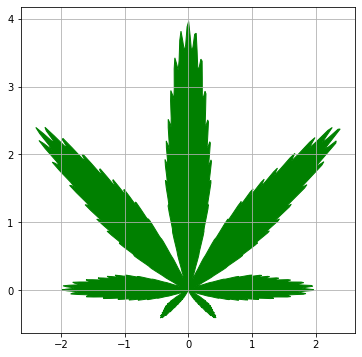

In [785]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=(6,6))
plt.fill(x, y, color='green')
plt.grid()

In [786]:
assert \
    np.allclose(x.sum(), -1.9854999999997989, atol=1e-4) and \
    np.allclose(y.mean(), 0.44955, atol=1e-4), \
    "Task 1: you've made an error somewhere"
print("Task 1: well done!")

Task 1: well done!


## Task 2 (7 points)

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

In case you skipped the above hyperlink, here are the rules:
* You have a 2D grid of cells, where each cell is "alive" or "dead" (has a value of `1` or `0` respectively).
* At each step in time, the so-called "generation update" happens:
  * any alive cell that has 2 or 3 neighbors survives, otherwise (0, 1 or 4+ neighbors) it dies;
  * any cell with exactly 3 neighbors becomes alive if it was dead.

You are given a reference numpy implementation of the generation update. Your task is to convert it to PyTorch. Try to avoid datatype conversions.

In [0]:
from scipy.signal import correlate2d as conv2d

def game_of_life_update_numpy(alive_map):
    """
    Game of Life update function.
    
    alive_map:
        `numpy.ndarray`, ndim == 2, dtype == `np.int64`
        The game map containing 0s (dead) an 1s (alive).
    """
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]], dtype=np.int64)
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    # print(num_alive_neighbors.shape)
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    
    np.copyto(alive_map, np.logical_or(born, survived))

In [0]:
def game_of_life_update_torch(alive_map):
    """
    PyTorch version of `game_of_life_update_numpy`.
    
    alive_map:
        `torch.tensor`, ndim == 2, dtype == `torch.int64`
        The game map containing 0s (dead) an 1s (alive).

    """
    conv_kernel = torch.tensor([[1,1,1],
                            [1,0,1],
                            [1,1,1]], dtype=torch.int64)
    conv = torch.zeros(alive_map.shape)
    alivem = alive_map
    alive_map = alive_map.numpy()
    alive_map = np.pad(alive_map, (1,1),'constant', constant_values=(0))
    alive_map  = torch.from_numpy(alive_map )
#         print(inpt.shape)
    for k in range(conv.shape[0]):
      for l in range (conv.shape[1]):
         for i in range(conv_kernel.shape[0]):
           for j in range(conv_kernel.shape[1]):
             conv[k,l] += alive_map[k+i,l+j] * conv_kernel[i, j]
    num_alive_neighbors = conv
    # print(num_alive_neighbors.shape)
    born = (num_alive_neighbors == 3)&( alivem == 0)
    survived = ((num_alive_neighbors == 2)| (num_alive_neighbors ==3)) & (alivem == 1)
    alive_map = alivem
    alive_map.copy_(born | survived)
    # Your code here

In [0]:
for _ in range(10):
    # Generate a random initial map
    alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
    alive_map_torch = torch.from_numpy(alive_map_numpy).clone()

    game_of_life_update_numpy(alive_map_numpy)
    game_of_life_update_torch(alive_map_torch)

    # Results must be identical
    assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
        "Your PyTorch implementation doesn't match numpy_update."

print("Task 2: well done!")

Task 2: well done!


In [0]:
animation = Animation(monochrome=True)

# Initialize game field
np.random.seed(777)
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.from_numpy(alive_map)

for _ in range(101):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    game_of_life_update_torch(alive_map)

animation.display()

KeyboardInterrupt: ignored

In [0]:
animation = Animation(monochrome=True)

# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros((100, 100), dtype=np.int64)
alive_map[48:52, 50] = 1

alive_map = torch.from_numpy(alive_map)

for _ in range(150):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    game_of_life_update_torch(alive_map)

animation.display()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: *notMNIST* dataset of 10 letters and ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% validation accuracy,
2. at least 2 linear layers,
3. no convolutions,
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

Tips:

* Don't use the structures from homework 1 (`Sequential`, `.forward()` etc.). I suggest that your `NeuralNet.predict()` consists of 5-7 lines.
* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

Happy googling!

I USED NAME "FORWARD" INSTEAD OF "PREDICT"!!!!!!!!! I CANT REMEMBER WHY I DECIDED TO CHANGE THE NAME (MAYBE WHILE GOOGLING I CAME ACROSS NAME "FORWARD" AND DECIDED TO USE IT NOT TO GET MIXED EVERYTHING IN MY HEAD!! I AM SO SORRY THAT I HAVE NOT CHANGE THE NAME! 
I WANT TO WARN YOU THAT I DIDNT CHANGE ANYTHING IN THE MODEL BESIDES PART WITH TORCH NO GRAD AND I DECIDED NOT TO DELETE "PREDICT METHOD" BUT PLEASE, CHECK THE METHOD FORWARD INSTEAD OF PREDICT.  I USED FORWARD EVERYWHERE : IN TRAINING AND IN VALIDATING!!


BECAUSE OF LIMITED TIMING I ALSO DECREASED THENUMBER OF EPOCHS

In [400]:
letters = 'ABCDEFGHIJ'
X_train, y_train, X_val, y_val = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_val.squeeze_();

Parsing... (it's OK if <10 images are broken)
Found broken image: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Found broken image: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


In [0]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
ohot_encoder = OneHotEncoder(categories=[range(10)])

y_train_hot = torch.tensor(ohot_encoder.fit_transform(y_train.reshape(-1, 1)).todense())
y_val_hot = torch.tensor(ohot_encoder.transform(y_val.reshape(-1, 1)).todense())
# y_test_hot = torch.tensor(ohot_encoder.transform(y_test.reshape(-1, 1)).todense())

In [402]:
X_train = torch.tensor(X_train.reshape(X_train.shape[0], -1))
X_val = torch.tensor(X_val.reshape(X_val.shape[0], -1))
# X_test = X_test.reshape(X_test.shape[0], -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [403]:
X_train.shape

torch.Size([14043, 784])

In [404]:
set(y_train.numpy())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

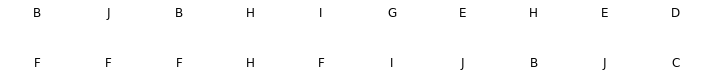

In [783]:
fig, axarr = plt.subplots(2, 10, figsize=(10, 2))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx].unsqueeze(0), cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

fig.tight_layout()

In [0]:
np.random.seed(777)
torch.manual_seed(777);

In [0]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [0]:
class NeuralNet:
  def __init__(self):
    # Your code here
    self.inputSize = 784
    self.outputSize = 10
    self.hiddenSize = 2000
    self.batch_size = 512
    self.n_epoch =10
    # weights
    stdv = 1./np.sqrt(self.inputSize)
    # self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
    self.W1 = torch.randn((784,64), requires_grad=True)
    self.b1 =torch.zeros(64, requires_grad=True)
    
    self.W2 = torch.randn((64,10), requires_grad=True)
    self.b2 =torch.zeros(10, requires_grad=True)
   
    self.crit_loss = 0
  def predict(self, X_val, y_val):
    """
    images:
        `torch.tensor`, shape == `batch_size x height x width`, dtype == `torch.float32`
        A minibatch of images -- the input to the neural net.
    
    return:
    prediction:
        `torch.tensor`, shape == `batch_size x 10`, dtype == `torch.float32`
        The probabilities of each input image to belong to each of the dataset classes.
        Namely, `output[i, j]` is the probability of `i`-th
        minibatch sample to belong to `j`-th class.
    """
    # Your code here
    loss_h = []
    acc= []
    for x_batch, y_batch in get_batches((X_val, y_val_hot), self.batch_size):
      predictions = self.forward(x_batch)
      print(predictions.shape)
      print(y_batch.shape)
      print()
      model_preds = torch.argmax(predictions, 1)
      acc.append(((predictions == y_batch).sum()) / y_batch.shape[0])
      loss = self.Criterion( y_batch)
          # print(loss)
      loss_h.append(loss)
    return loss_h, loss, acc


  def train(self,X_train, y_train_hot):
    loss_h = []
    for i in range(self.n_epoch):
      for x_batch, y_batch in get_batches((X_train, y_train_hot), self.batch_size):
          predictions = self.forward(x_batch)
          loss = self.Criterion( y_batch)          
          loss_h.append(loss)
          self.crit_loss.backward()
          self.do_backward()
      loss_h.append(10000000000*(i+1))
          
    return loss_h, loss

  
  def Criterion(self, target):
    input_clamp = torch.clamp(self.answers, 1e-10, 1 - 1e-10)
    
#         self.crit_loss = -(torch.log(input_clamp[:,target])).sum()
    self.crit_loss = -(torch.log(input_clamp.gather(1, target.view(-1,1)))).sum()
    self.crit_loss.data = self.crit_loss.data/self.answers.shape[0]
    return self.crit_loss
    


  def forward(self, X):
    self.l1 = torch.matmul(X, self.W1)+self.b1
    self.act1 = torch.relu(self.l1) 
    self.l2 = torch.matmul(self.act1, self.W2)+self.b2
    self.act2 = torch.relu(self.l2)    
    self.answers = self.act2.softmax(dim=1)
    
    return self.answers

  def backward(self, X, error, predictions):
    self.gradSM = self.outputSM*(error - torch.sum(self.outputSM*error, axis=1).reshape(-1,1))
   
    self.gradact2 = self.gradSM*self.ELUback(self.act2)
    self.gradl2 = torch.matmul(self.gradact2, torch.t(self.W2))
    self.gradact1 = self.gradl2*self.ELUback(self.act1)
    self.W1 -= torch.matmul(torch.t(X), self.gradact1)*0.0001
    # print(self.gradact1.shape)
    self.W2 -= torch.matmul(torch.t(self.act1), self.gradSM )*0.0001
    self.b1 -= torch.sum(self.gradact1, axis=0)*0.0001
    self.b2 -= torch.sum(self.gradSM, axis=0)*0.0001

  def do_backward(self):
      self.W1.data = self.W1.data - 0.0001*self.W1.grad.data
      self.b1.data = self.b1.data - 0.0001*self.b1.grad.data
      
      self.W2.data = self.W2.data - 0.0001*self.W2.grad.data
      self.b2.data = self.b2.data - 0.0001*self.b2.grad.data


      with torch.no_grad():
      
        self.W2.grad = torch.zeros_like(self.W2)
        self.b2.grad = torch.zeros_like(self.b2)
        self.W1.grad = torch.zeros_like(self.W1)
        self.b1.grad = torch.zeros_like(self.b1)

  # def SoftMax(self, input):
  #   out = torch.zeros(input.shape,  dtype = torch.float32) #, dtype = 'torch.float32')
  #   for i in range(input.shape[0]):
  #       # a = torch.mean(input[i])
  #       # norm = torch.sum(torch.tensor([torch.exp(k) for k in input[i]]), dtype = torch.float32)
  #       norm = torch.sum(torch.exp(input[i]), dtype = torch.float32)
  #       # print(norm ==0)
  #       for j in range(input.shape[1]):
  #           el = torch.exp(input[i][j]) / norm
  #           out[i][j] = el
  #   self.outputSM = out
  #   return self.outputSM


  # Your code here

In [0]:
def accuracy(model, images, labels):
    """
    model:
        `NeuralNet`
    images:
        `torch.tensor`, shape == `N x height x width`, dtype == `torch.float32`
    labels:
        `torch.tensor`, shape == `N`, dtype == `torch.int64`
        Class indices for each sample in `images`.
    
    return:
    value:
        `float`
        The fraction of samples from `images` correctly classified by `model`.
        `0 <= value <= 1`.
        
    """
    predictions = model.forward(images)
    predictions = torch.argmax(predictions, axis=1)
    
    return torch.mean((labels==predictions).float())
    # Your code here

In [0]:

model = NeuralNet()


In [761]:
%%time
losshis , loss = model.train(X_train, y_train)

CPU times: user 3.06 s, sys: 26.9 ms, total: 3.09 s
Wall time: 3.16 s


In [0]:
preds = model.forward(X_val)



In [764]:
predictions = torch.argmax(preds, 1)
((predictions == y_val).sum())*100.0 / y_val.shape[0]

tensor(85.6868)

In [0]:
w1 = model.W1
b1 = model.b1
w2 = model.W2
b2 = model.b2


In [0]:
dictt = {'w1': w1, 'b1':b1,'w2': w2, 'b2':b2,}

In [0]:
name = 'mnist2'
torch.save(dictt, f'drive/My Drive/{name}.pth')

In [782]:
# dd= torch.load('drive/My Drive/mnist.pth')
# dd.keys()
# model2 =NeuralNet()
# model2.b1 = dd['b1']
# model2.b2 = dd['b2']
# model2.W1 = dd['w1']
# model2.W2 = dd['w2']
# accuracy(model2, X_val, y_val)

tensor(87.8658)

In [0]:
dd2= torch.load('drive/My Drive/mnist2.pth')
model3 =NeuralNet()
model3.b1 = dd2['b1']
model3.b2 = dd2['b2']
model3.W1 = dd2['w1']
model3.W2 = dd2['w2']

In [788]:
accuracy(model3, X_val, y_val)

tensor(85.6868)

In [779]:
%%time
torch.set_num_threads(1)

# Your code here (train the model)

CPU times: user 115 µs, sys: 0 ns, total: 115 µs
Wall time: 120 µs


In [801]:
train_accuracy = accuracy(model, X_train, y_train) * 100
val_accuracy = accuracy(model, X_val, y_val) * 100
print("Training accuracy: %.2f, validation accuracy: %.2f" % (train_accuracy, val_accuracy))

assert val_accuracy >= 82.0, "You have to do better"
print("Task 3: well done!")

Training accuracy: 87.14, validation accuracy: 85.69
Task 3: well done!


In [802]:
train_accuracy = accuracy(model3, X_train, y_train) * 100
val_accuracy = accuracy(model3, X_val, y_val) * 100
print("Training accuracy: %.2f, validation accuracy: %.2f" % (train_accuracy, val_accuracy))

assert val_accuracy >= 82.0, "You have to do better"
print("Task 3: well done!")

Training accuracy: 87.14, validation accuracy: 85.69
Task 3: well done!
